<a href="https://colab.research.google.com/github/NouranYoussef/bioinformatics_final/blob/main/bioinformatics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
from Bio import SeqIO
from Bio import AlignIO
import Bio.Seq
import os
import pandas as pd
import matplotlib.pyplot as plt

dir = './sequences/England/'

In [118]:
def parse_records(dir_='ref'):
  files = [file for file in os.listdir(dir+dir_)]

  records = []
  for file in files:
      for record in SeqIO.parse(dir + dir_+'/'+file, format='fasta'):
          records.append(record)
  return records

In [119]:
def parse_align(path, format='fasta'):
    alignments = AlignIO.parse(path, format=format)
    for records in alignments:
        return records


In [120]:
def chemical_content(seq):
    len_seq = len(seq)
    
    #A,C,G,T,CG counts 
    A_count = seq.count('A')
    C_count = seq.count('C')
    G_count = seq.count('G')
    T_count = seq.count('T')
    CG_count = C_count + G_count
    
    #percentage of the chemical constituents
    A_content= (A_count/len_seq)*100
    C_content = (C_count/len_seq)*100
    G_content = (G_count/len_seq)*100
    T_content = (T_count/len_seq)*100
    CG_content = (CG_count/len_seq)*100
    
    return {'A':A_content,'C':C_content,'G':G_content,'T':T_content,'CG':CG_content}

In [121]:
# This function returns IUPAC letter mapping to the probable nucleotides 
def map_IUPAC(bases):
    num = len(bases)
    if num == 1:
        return bases.pop()
    elif num == 2:
        if bases == set(['A', 'G']): # A or G
            return 'R'
        elif bases == set(['T', 'C']):
            return 'Y'
        elif bases == set(['A', 'C']):
            return 'M'        
        elif bases == set(['T', 'G']):
            return 'K'
        elif bases == set(['C', 'G']):
            return 'S'
        elif bases == set(['A', 'T']):
            return 'W'
        else:
            b = bases.pop()
            if b != '-':
                return b
            else:
                return bases.pop()
    elif num == 3:
        if bases == set(['A', 'C', 'T']): # not G
            return 'H'
        elif bases == set(['G', 'C', 'T']): # not A
            return 'B'        
        elif bases == set(['A', 'C', 'G']): # not T
            return 'V'        
        else: # bases == set(['A', 'G', 'T']): # not C
            return 'D' 
    else: # Any
        return 'N'

# This function returns a list of the count of each nucleotide at each location
def count_bases(records):
    base_count = []
    for i in range(records.get_alignment_length()):
        counts = dict()
        for record in records:
            counts[record.seq[i]] = counts.get(record.seq[i], 0) + 1
        base_count.append(counts)
    return base_count   


In [122]:
# This function chooses the dominant base letter at each location 
def construct_consensus(records, threshold=0.7):
    bases_count = count_bases(records)
    num_records = len(records)
    consensus = ''
    for location in bases_count:
        bases = set()
        for base in location:
            base_percent = location[base]/num_records
            if base_percent > threshold:
                bases.add(base)

        consensus += map_IUPAC(bases)
    return consensus 

In [123]:
def write_consensus(cov_consensus, omicron_consensus, filename):
    sequences = cov_records[:2]
    sequences[0].seq = cov_consensus
    sequences[0].id = 'cov_consensus'
    sequences[0].description = 'cov_consensus'
    sequences[1].seq = omicron_consensus
    sequences[1].id = 'omicron_consensus'
    sequences[1].description = 'omicron_consensus'

    SeqIO.write(sequences, filename, "fasta")


In [124]:
# 
def get_dissimilar_locations(seq1, seq2):
    return [i for i in range(len(seq1)) if seq1[i] != seq2[i]]

def get_dissimilar_regions(locations):
    dissimilar_regions = []
    last_region = {'start': locations[0], 'end': locations[0]}
    for loc in locations:
        if(loc == (last_region['end'] + 1)):
            last_region['end'] = loc
        else:
            if(loc != locations[0]): 
                dissimilar_regions.append(last_region)
            last_region = {'start': loc, 'end': loc}

        if(loc == locations[-1]):
            dissimilar_regions.append(last_region)

    return dissimilar_regions


In [125]:
def write_regions(regions, path='./Results/',  filename='regions.txt'):
    dir = path + filename
    with open(dir, 'w') as f:
        f.write("Aligned consensus sequences length: "+ str(len(cons_alignment[0].seq) ))
        f.write('\n')
        f.write("Number of dissimilar regions: " + str(len(diff_regions)))
        f.write('\n\n')
        f.write("Regions:\n")
        for region in regions:
            f.write("\tstart location: "+str(region['start']))
            f.write('\n')
            f.write("\tcovid19:  "+str(cons_alignment[0].seq[region['start']:region['end']+1]))
            f.write('\n')
            f.write("\tomicron:  "+str(cons_alignment[1].seq[region['start']:region['end']+1]))
            f.write('\n')
            f.write("\n\n")
    f.close()

In [126]:
def regions_analysis(regions):
    point_mutations_count = 0
    point_mutations = {}
    short_del = 0
    short_insertion = 0
    short_del_count = 0
    short_insertion_count = 0
    short_indel = []
    all_percent = 0
    other_variants = []
    variants_length = 0
    print("Total number of regions = " + str(len(regions)))
    for region in regions:
        all_percent += region['end'] + 1 - region['start'] 

        # point mutation
        if(region['start'] == region['end']): 
            point_mutations_count +=1
            from_base_to_base = cons_alignment[0].seq[region['start']]+"_" + cons_alignment[1].seq[region['start']]
            point_mutations[from_base_to_base] = point_mutations.get(from_base_to_base, 0) + 1

        #short deletion
        elif(cons_alignment[0].seq[region['end']:region['end']+1] == '-' and cons_alignment[0].seq[region['start']] == '-'):
            short_del += region['end'] + 1 - region['start'] 
            short_del_count += 1
            short_indel.append({'deletion': region})

        # short insertion
        elif(cons_alignment[1].seq[region['end']:region['end']+1] == '-' and cons_alignment[1].seq[region['start']] == '-'):
            short_insertion += region['end'] + 1 - region['start'] 
            short_insertion_count += 1
            short_indel.append({'insertion': region})
            # print(cons_alignment[0].seq[region['start']:region['end']+1])
            # print(cons_alignment[1].seq[region['start']:region['end']+1])

        else:
            # print( region['end'] + 1 - region['start'])
            variants_length += region['end'] + 1 - region['start'] 
            other_variants.append(region)

    align_length = len(cons_alignment[0].seq) 
    points_percent = (point_mutations_count/align_length)*100

    
    print("Number of point mutations = " + str(point_mutations_count))
    print("Percentage of point mutations = %.2f" % points_percent + "%")

    indels_percent = ((short_del+short_insertion)/align_length)*100
    # print("Number of short inserions = " + str(short_insertion_count))
    # print("Number of short deletions = " + str(short_del_count))
    print("Number of short indels = " + str(short_del_count+short_insertion_count))
    print("Percentage of short indels = %.2f" %indels_percent + "%")

    # print("Total length of short inserions = " + str(short_insertion))
    # print("Total length of short deletions = " + str(short_del))
    # print("Total length of short indels = " + str(short_del + short_insertion))

    var_percent = (variants_length/align_length)*100
    print("Number of other variants = " + str(len(other_variants)))
    print("Percentage of other variants = %.2f" %var_percent + "%")



    indel_percentages = {'Deletion': (short_del/align_length) *100, 
                       'Insertion': (short_insertion/align_length) *100}
    all_percent = (all_percent/align_length)*100
    print("Total percentage of dissimilar regions = %.2f" % all_percent + "%")    
    # print("Total percentage of dissimilar regions = "+str(indels_percent+var_percent+points_percent)+"%")    
    
    return point_mutations, short_indel, indel_percentages, other_variants

## Read Records

In [127]:
cov_records = parse_records('ref')
omicron_records = parse_records('omicron')
# print(omicron_records[0])

## Chemical Constituents Contents

In [128]:
#construct list of chemical contents dicts
content_dicts=[]
for record in omicron_records:
  content_dicts.append(chemical_content(record.seq))

#construct dataframe of the contents and caculate avergae of each chemical constituent content 
df_omicron = pd.DataFrame.from_dict(content_dicts).T
df_omicron['avg'] = df_omicron.mean(axis=1)
df_omicron


,0,1,2,3,4,5,6,7,8,9,avg
A,27.709993,29.469799,29.640719,29.426174,29.941685,29.706634,29.526850,29.387257,29.423025,28.931031,29.316317
C,17.054889,18.000000,18.155823,17.983221,18.288759,18.190688,18.008899,17.908072,17.943982,17.688367,17.922270
G,18.221236,19.322148,19.481262,19.312081,19.569006,19.522944,19.374342,19.286658,19.320930,18.984293,19.239490
T,30.096467,31.701342,31.935006,31.694631,32.153630,32.064998,31.860331,31.704095,31.642934,31.244699,31.609813
CG,35.276125,37.322148,37.637085,37.295302,37.857765,37.713632,37.383241,37.194730,37.264911,36.672660,37.161760


In [129]:
#construct list of chemical contents dicts
content_dicts2=[]
for record in cov_records:
  content_dicts2.append(chemical_content(record.seq))

#construct dataframe of the contents and caculate avergae of each chemical constituent content 
df_cov = pd.DataFrame.from_dict(content_dicts2).T
df_cov['avg'] = df_cov.mean(axis=1)
df_cov

,0,1,2,3,4,5,6,7,8,9,avg
A,28.232483,29.864710,29.864710,29.746921,28.239214,29.864710,29.861345,29.857979,29.868076,29.883401,29.528355
C,17.365552,18.371811,18.378542,18.287676,17.365552,18.371811,18.371811,18.361715,18.375177,18.381023,18.163067
G,18.472774,19.627112,19.627112,19.549707,18.466043,19.630477,19.627112,19.630477,19.623746,19.620720,19.387528
T,30.103655,32.136367,32.129636,31.988288,30.103655,32.133001,32.139732,32.149828,32.133001,32.114856,31.713202
CG,35.838325,37.998923,38.005654,37.837383,35.831595,38.002288,37.998923,37.992192,37.998923,38.001742,37.550595


<AxesSubplot:xlabel='chemical constitute', ylabel='differnece in content %'>

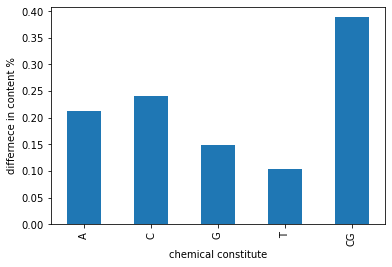

In [130]:
#differents of contents 
diff_content = df_cov.avg - df_omicron.avg

fig, ax = plt.subplots()
ax.set_ylabel("differnece in content %")
ax.set_xlabel("chemical constitute")
diff_content.plot(kind='bar',ax=ax)

## Construct Consensus Sequenses

In [131]:
# Read Alignments
cov_alignments = parse_align('./sequences/ref_alignment.fas', 'fasta')
omicron_alignments = parse_align('./sequences/omicron_alignment.fas', 'fasta')

In [132]:
cov_consensus = construct_consensus(cov_alignments, threshold=0.5)
omicron_consensus = construct_consensus(omicron_alignments, threshold=0.5)

print(len(cov_consensus))
print(len(omicron_consensus))

29870
30217


In [140]:
# Trying the biopython consensus sequence package to compare
from Bio.Align import AlignInfo
threshold = 0.7
cov_consensus_ = AlignInfo.SummaryInfo(cov_alignments).gap_consensus(ambiguous='N', threshold=threshold)
omicron_consensus_ = AlignInfo.SummaryInfo(omicron_alignments).gap_consensus(ambiguous='N', threshold=threshold)

cov_consensus_nogaps = AlignInfo.SummaryInfo(cov_alignments).dumb_consensus(ambiguous='N', threshold=threshold)
omicron_consensus_nogaps = AlignInfo.SummaryInfo(omicron_alignments).dumb_consensus(ambiguous='N', threshold=threshold)

print(cov_consensus_[0:200])
print(cov_consensus_nogaps[0:200])
# print(len(cov_consensus_))
# print(len(omicron_consensus))

-------------------------------------------------AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGT
AGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGT
29870


In [134]:
# Write the two consensus sequences to a fasta file resulting from both methods to pairwise align
write_consensus(cov_consensus_, omicron_consensus_, "consensus_sequenses.fasta")
write_consensus(Bio.Seq.Seq(cov_consensus), Bio.Seq.Seq(omicron_consensus), "consensus_sequenses2.fasta")

### Comparing the consenus sequence resulted from implemented function with the Biopython package result

In [143]:
locs = get_dissimilar_locations(cov_consensus, cov_consensus_)
if (locs):
    diss_regions = get_dissimilar_regions(locs)
    for region in diss_regions:
        print(region)
        print(cov_consensus[region['start']:region['end']+1]) #implemented result
        print(cov_consensus_[region['start']:region['end']+1]) #biopython result

## Aligning the reference consensus sequense with the cases consensus sequence

In [110]:
# from Bio import pairwise2

# cons_alignment = pairwise2.align.globalxx(cov_consensus, omicron_consensus, one_alignment_only=True)

# cons_alignment2 = parse_align('./Consensus_alignment.fas') #threshold = 0.7
cons_alignment = parse_align('./Consensus_alignment2.fas')

print("The length of sequnce alignment: " + str(len(cons_alignment[0])))

The length of sequnce alignment: 29796


## Dissimilar Regions

In [111]:
diff_loc = get_dissimilar_locations(cons_alignment[0].seq, cons_alignment[1].seq) 

diff_regions = get_dissimilar_regions(diff_loc)


print("Number of dissimilar regions: " + str(len(diff_regions)))

# Write regions into text file
write_regions(diff_regions)

Number of dissimilar regions: 73


## Analyze Dissimilar Regions

In [112]:
point_mutations, short_indel, indel_percentages, other_variants = regions_analysis(diff_regions)

Total number of regions = 73
Number of point mutations = 60
Percentage of point mutations = 0.20%
Number of short indels = 8
Percentage of short indels = 0.37%
Number of other variants = 5
Percentage of other variants = 1.19%
Total percentage of dissimilar regions = 1.76%


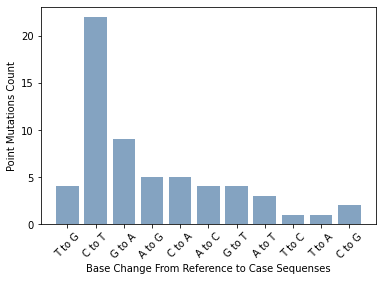

In [113]:
fig, ax = plt.subplots()
ax.set_ylabel("Point Mutations Count")
ax.set_xlabel("Base Change From Reference to Case Sequenses")
names = []
values = []
for key, val in point_mutations.items():
    names.append(key[0]+ " to " + key[2])
    values.append(val)

plt.bar(range(len(names)), values, tick_label=names, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(rotation=45) 

plt.show()

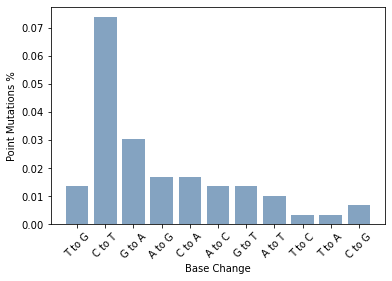

In [114]:
fig, ax = plt.subplots()
ax.set_ylabel("Point Mutations %")
ax.set_xlabel("Base Change")
names = []
values = []
for key, val in point_mutations.items():
    names.append(key[0]+ " to " + key[2])
    values.append((val/len(cons_alignment[0].seq))*100)

plt.bar(range(len(names)), values, tick_label=names, color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(rotation=45) 

plt.show()

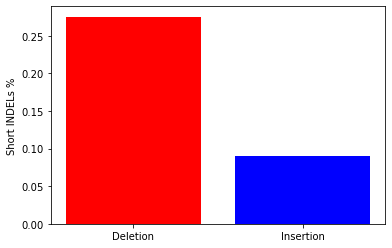

In [115]:
names = []
values = []
for key,val in indel_percentages.items():
    names.append(key) 
    values.append(val)
fig, ax = plt.subplots()
ax.set_ylabel("Short INDELs %")

plt.bar(range(len(names)), values, tick_label=names, color=['r', 'b'])
plt.show()